In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import copy, time

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Ecommerce Dataset

This dataset is a synthetic e-commerce dataset designed to provide a comprehensive view of transaction, customer, product, and advertising data in a dynamic marketplace. The dataset includes detailed transaction-level data featuring product categories, customer demographics, discounts, revenue, and advertising metrics such as impressions, clicks, conversion rates, and ad spend.

In [3]:
df = pd.read_csv('synthetic_ecommerce_data.csv')

In [4]:
df.sample(5)

,Transaction_ID,Customer_ID,Product_ID,Transaction_Date,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Category,Region,Ad_CTR,Ad_CPC,Ad_Spend
73188,8f6c64e2-cee4-49dd-9afe-1365ca7a8f8a,Customer_18414,Product_965,2024-03-28,123,0.03,376.48,48,258,0.19,Clothing,Asia,0.0393,0.43,16.90
10512,2ae8b5d5-b339-46b9-8dc5-f135cfdb531b,Customer_16247,Product_892,2023-12-31,95,0.20,372.96,49,156,0.31,Clothing,North America,0.1624,0.25,40.60
58104,42366528-bb06-4ea5-aa8d-90e02ccc49c4,Customer_5831,Product_297,2024-06-22,115,0.01,305.70,23,313,0.07,Electronics,North America,0.0754,0.48,36.19
48538,5406601e-d906-4a44-9835-05caf46171bf,Customer_1379,Product_860,2024-04-18,165,0.14,666.35,18,183,0.10,Books,Europe,0.0340,0.27,9.18
23116,90bdc420-24e3-4d10-b135-08a3f6192e3d,Customer_11518,Product_165,2024-11-01,159,0.17,26.08,42,358,0.12,Clothing,Asia,0.0429,1.78,76.36


In [5]:
print("Number of Transactions: ", df["Transaction_ID"].nunique())
print("Number of Customers: ", df["Customer_ID"].nunique())
print("Number of Products: ", df["Product_ID"].nunique())

Number of Transactions:  100000
Number of Customers:  19865
Number of Products:  1000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    100000 non-null  object 
 1   Customer_ID       100000 non-null  object 
 2   Product_ID        100000 non-null  object 
 3   Transaction_Date  100000 non-null  object 
 4   Units_Sold        100000 non-null  int64  
 5   Discount_Applied  100000 non-null  float64
 6   Revenue           100000 non-null  float64
 7   Clicks            100000 non-null  int64  
 8   Impressions       100000 non-null  int64  
 9   Conversion_Rate   100000 non-null  float64
 10  Category          100000 non-null  object 
 11  Region            100000 non-null  object 
 12  Ad_CTR            100000 non-null  float64
 13  Ad_CPC            100000 non-null  float64
 14  Ad_Spend          100000 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 11.4+ MB


In [7]:
df.describe()

,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Ad_CTR,Ad_CPC,Ad_Spend
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,128.328580,0.149871,553.110811,24.539170,254.539060,0.198138,0.104988,1.051250,110.477240
std,49.679873,0.086692,428.366294,14.412477,141.466606,0.361187,0.054806,0.549252,87.015846
min,51.000000,0.000000,7.650000,0.000000,10.000000,0.000000,0.010000,0.100000,1.050000
25%,84.000000,0.070000,221.260000,12.000000,132.000000,0.050000,0.057500,0.580000,38.610000
50%,127.000000,0.150000,428.155000,25.000000,254.000000,0.100000,0.105200,1.050000,87.240000
75%,166.000000,0.220000,805.865000,37.000000,377.000000,0.190000,0.152300,1.530000,164.220000
max,716.000000,0.300000,5704.180000,49.000000,499.000000,4.900000,0.200000,2.000000,399.600000


### 1. Dataset Description

The ``bar chart`` displays the number of transactions for each product category, revealing the relative popularity of each category.

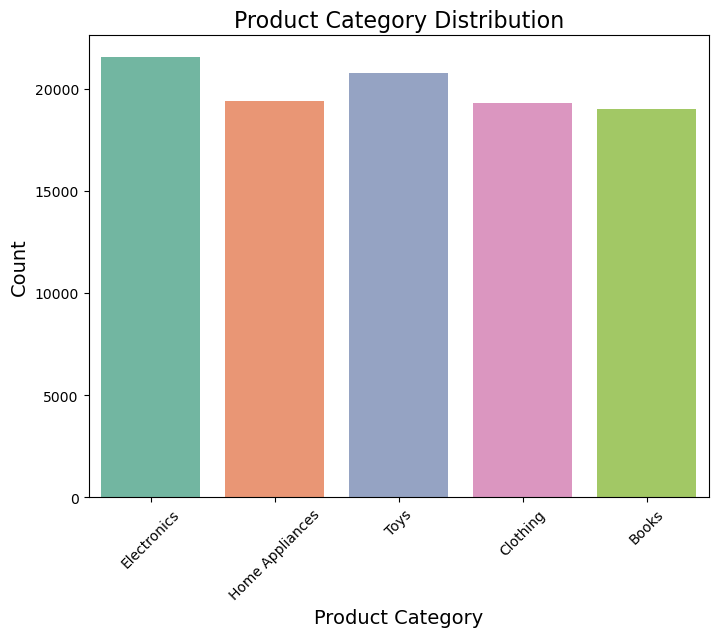

In [8]:
# Plot a bar chart for the 'Category' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Category', palette='Set2', hue = 'Category')
plt.title("Product Category Distribution", fontsize=16)
plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

The ``bar chart`` shows the total number of units sold for each product category, highlighting the sales volume across categories.

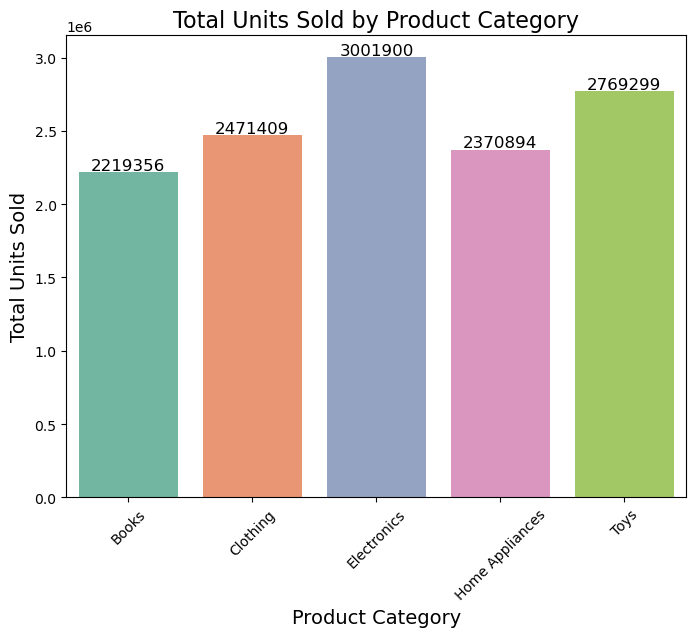

In [9]:
# Aggregate Units_Sold by Category
category_units_sold = df.groupby('Category')['Units_Sold'].sum().reset_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=category_units_sold, x='Category', y='Units_Sold', palette='Set2', hue = 'Category')

# Add the total units sold on top of each bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),  # Format the number
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text
        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),  # Style
        textcoords='offset points'
    )

# Customize plot appearance
plt.title("Total Units Sold by Product Category", fontsize=16)
plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Total Units Sold", fontsize=14)
plt.xticks(rotation=45)
plt.show()

The plot shows the distribution of ``Units_Sold`` for each product category, with the average number of units sold displayed above each box.

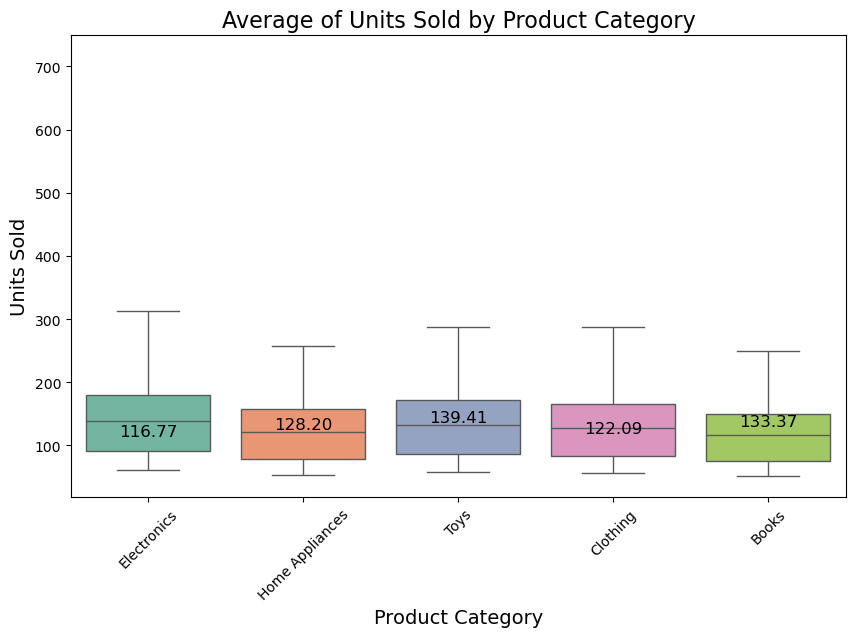

In [10]:
# Plot a boxplot for 'Units_Sold' by 'Category'
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='Category', y='Units_Sold', palette='Set2', hue = 'Category', flierprops=dict(marker='o', color='white', markersize=0))

# Calculate the average Units Sold for each Category
average_units_sold = df.groupby('Category')['Units_Sold'].mean().reset_index()

# Add the average number of units sold as text on the plot
for i, category in enumerate(average_units_sold['Category']):
    ax.text(i, average_units_sold.loc[i, 'Units_Sold'] + 5,  # Position the text slightly above the box
            format(average_units_sold.loc[i, 'Units_Sold'], '.2f'),  # Format the number
            ha='center', va='center', fontsize=12, color='black')

# Customize plot appearance
plt.title("Average of Units Sold by Product Category", fontsize=16)
plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Units Sold", fontsize=14)
plt.xticks(rotation=45)
plt.show()

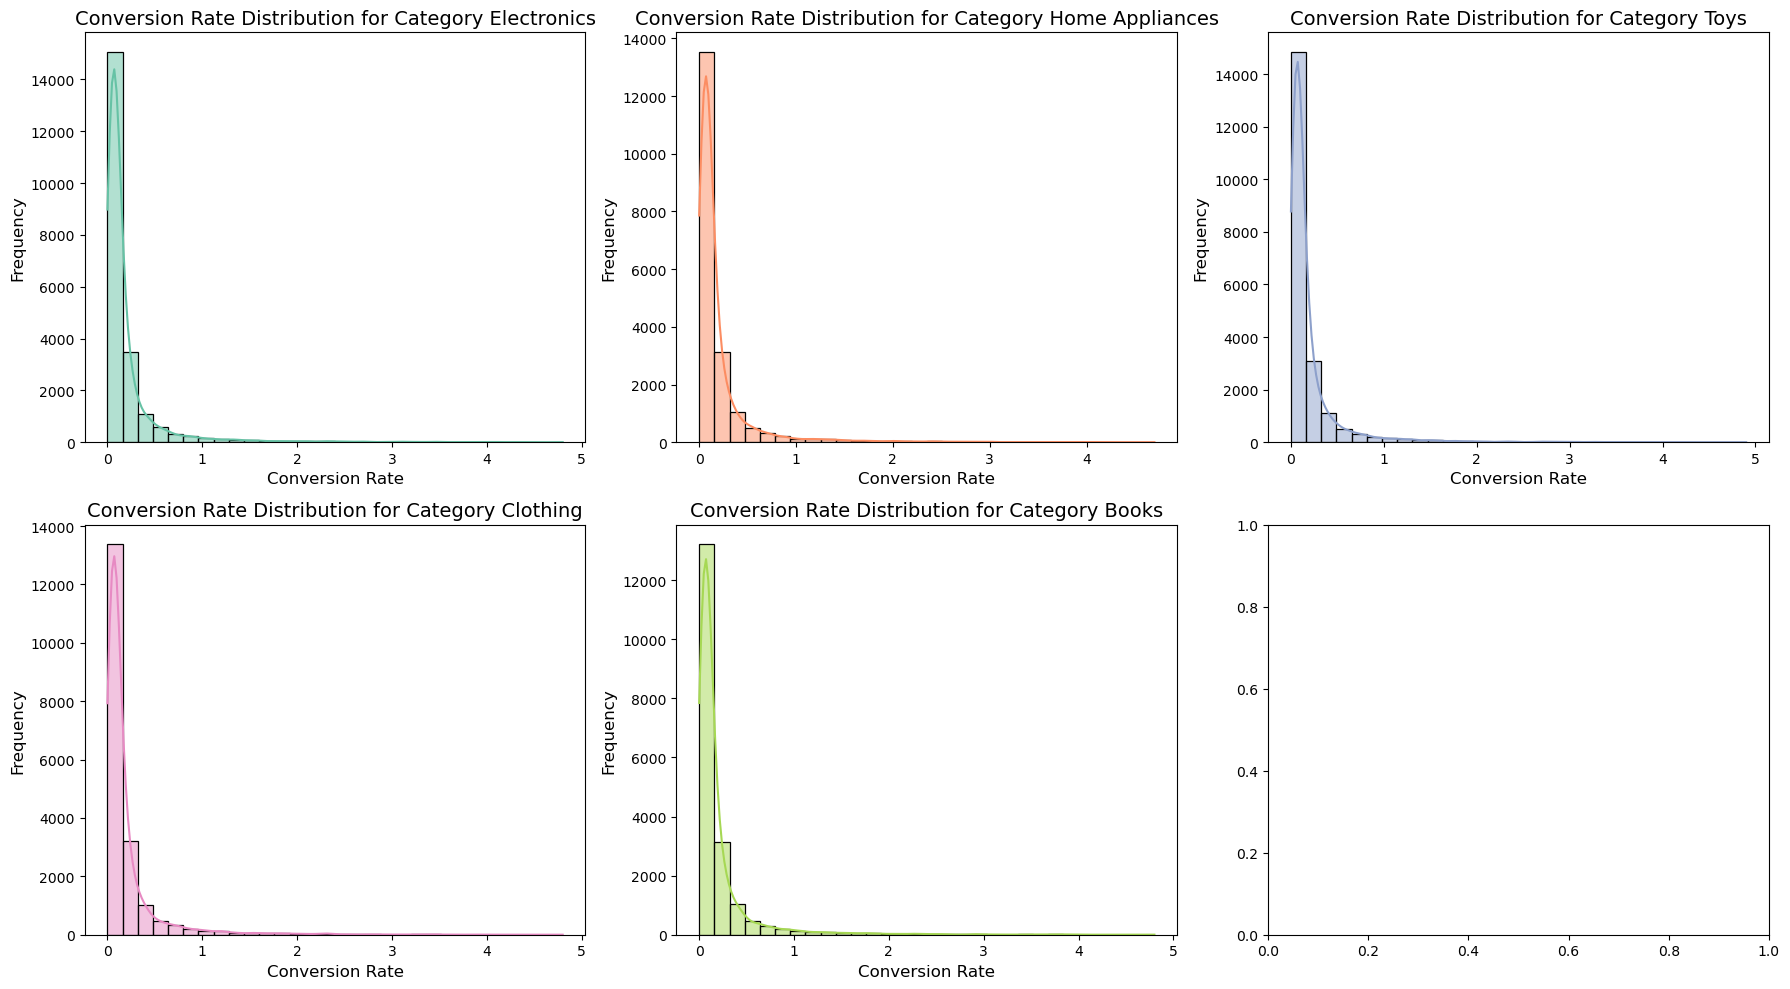

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique categories
categories = df['Category'].unique()

# Set up the subplots: 2 rows and 3 columns (adjust size accordingly)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define colors for each category
colors = sns.color_palette("Set2", n_colors=len(categories))

# Plot a histogram for each category in a separate subplot
for i, category in enumerate(categories):
    # Filter the data for the current category
    category_data = df[df['Category'] == category]
    
    # Plot the histogram for the current category with a specific color
    sns.histplot(data=category_data, x='Conversion_Rate', kde=True, color=colors[i], ax=axes[i], bins=30)
    
    # Customize each subplot
    axes[i].set_title(f"Conversion Rate Distribution for Category {category}", fontsize=14)
    axes[i].set_xlabel("Conversion Rate", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

The ``bar plot`` shows the total Units_Sold for each product category across different regions, with each region displayed in a separate subplot.

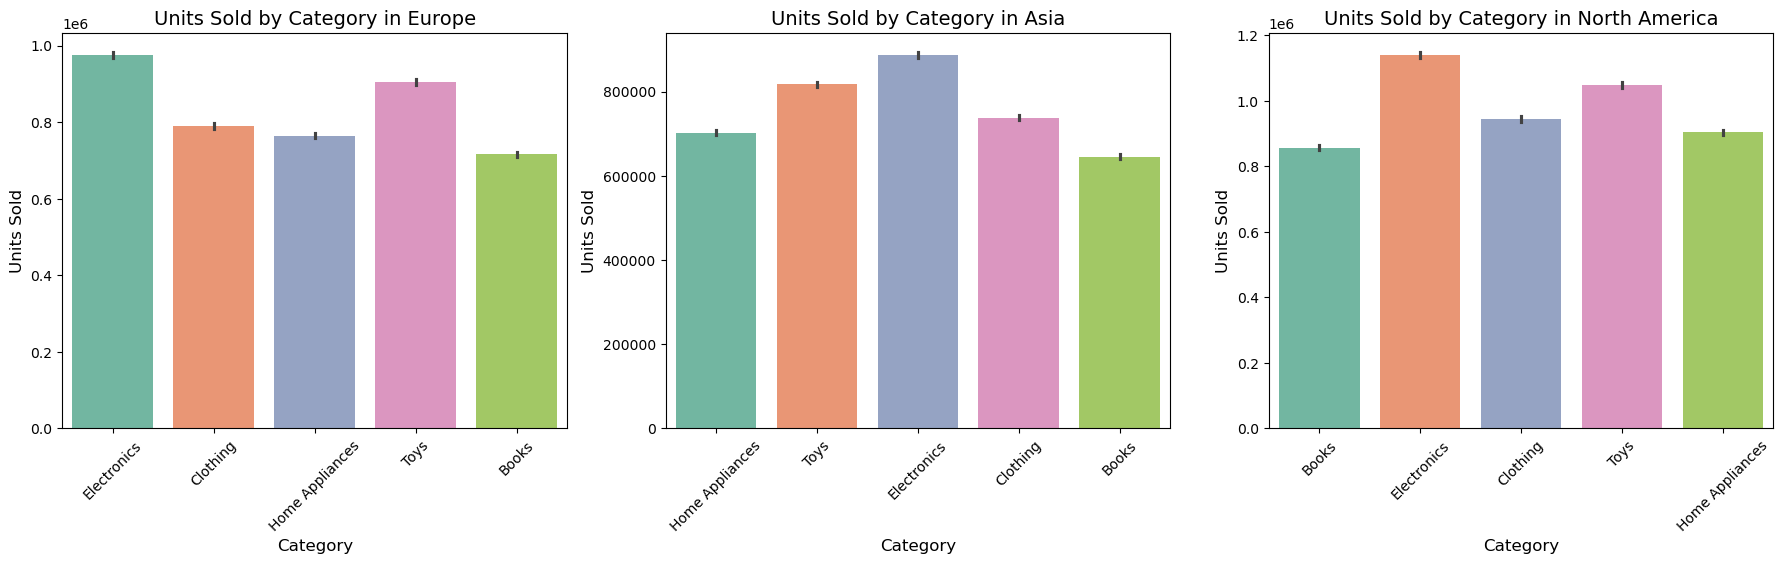

In [12]:
# Get unique regions
regions = df['Region'].unique()

# Set up the subplots: Adjust rows and columns as needed
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot a bar chart for each region
for i, region in enumerate(regions):
    # Filter data for the current region
    region_data = df[df['Region'] == region]
    
    # Plot the bar chart for Units Sold by Category in the current region
    sns.barplot(data=region_data, x='Category', y='Units_Sold', ax=axes[i], palette='Set2', estimator=sum, hue = 'Category')
    
    # Customize each subplot
    axes[i].set_title(f"Units Sold by Category in {region}", fontsize=14)
    axes[i].set_xlabel("Category", fontsize=12)
    axes[i].set_ylabel("Units Sold", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(len(regions), len(axes)):
   fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### 2. Define Dataset and Dataset Preprocessing

In [13]:
class Ecommerce_Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        
        # Extract categorical and numerical columns
        self.customer_ids = torch.tensor(data['Customer_ID'].values, dtype=torch.long)
        self.product_ids = torch.tensor(data['Product_ID'].values, dtype=torch.long)
        self.categories = torch.tensor(data['Category'].values, dtype=torch.long)
        self.numerical_features = torch.tensor(data[['Units_Sold', 'Clicks', 'Impressions']].values, dtype=torch.float32)
        self.targets = torch.tensor(data['Conversion_Rate'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'customer_id': self.customer_ids[idx],
            'product_id': self.product_ids[idx],
            'category': self.categories[idx],
            'numerical': self.numerical_features[idx],
            'target': self.targets[idx]
        }

#### Data Preprocessing
1. **Categorical Encoding**: The categorical columns ``Customer_ID``, ``Product_ID``, and ``Category`` are encoded into numerical codes using pandas' Categorical method.
2. **Z-Score Normalization**: The numerical columns ``Units_Sold``, ``Clicks``, ``Impressions``, and ``Conversion_Rate`` are normalized to have a mean of 0 and a standard deviation of 1.

In [14]:
# Extract important features from the dataset
features = ['Customer_ID', 'Product_ID', 'Category', 'Units_Sold', 'Clicks', 'Impressions', 'Conversion_Rate']
df_copy = df[features].copy()

# Train and Test dataset splitting
train_size = 0.8
test_size = 0.2
train_df, test_df = train_test_split(df_copy, test_size=test_size, random_state=42)

**Training Dataset** Preprocessing

In [15]:
# Step 1: Encode categorical columns
customer_id_mapping = {value: idx for idx, value in enumerate(df_copy['Customer_ID'].unique())}
product_id_mapping = {value: idx for idx, value in enumerate(df_copy['Product_ID'].unique())}
category_mapping = {value: idx for idx, value in enumerate(df_copy['Category'].unique())}

train_df['Customer_ID'] = train_df['Customer_ID'].map(customer_id_mapping)
train_df['Product_ID'] = train_df['Product_ID'].map(product_id_mapping)
train_df['Category'] = train_df['Category'].map(category_mapping)

# Step 2: Normalize numerical columns using Z-Score Standardization
stats = {
    'Units_Sold': {'mean': train_df['Units_Sold'].mean(), 'std': train_df['Units_Sold'].std()},
    'Clicks': {'mean': train_df['Clicks'].mean(), 'std': train_df['Clicks'].std()},
    'Impressions': {'mean': train_df['Impressions'].mean(), 'std': train_df['Impressions'].std()},
    'Conversion_Rate': {'mean': train_df['Conversion_Rate'].mean(), 'std': train_df['Conversion_Rate'].std()}
}

train_df['Units_Sold'] = (train_df['Units_Sold'] - stats['Units_Sold']['mean']) / stats['Units_Sold']['std']
train_df['Clicks'] = (train_df['Clicks'] - stats['Clicks']['mean']) / stats['Clicks']['std']
train_df['Impressions'] = (train_df['Impressions'] - stats['Impressions']['mean']) / stats['Impressions']['std']
train_df['Conversion_Rate'] = (train_df['Conversion_Rate'] - stats['Conversion_Rate']['mean']) / stats['Conversion_Rate']['std']

# Step 3: Display random samples from the preprocessed training data
train_df.sample(3)

,Customer_ID,Product_ID,Category,Units_Sold,Clicks,Impressions,Conversion_Rate
40054,4964,304,2,-0.465686,-1.074983,-1.524034,0.090691
28466,12469,323,3,-1.066944,-0.797512,1.051166,-0.466883
52993,16958,709,3,-0.405560,0.728575,-0.802412,0.146448


**Testing Dataset** Preprocessing

In [16]:
# Step 1: Apply categorical transform on testing data
test_df['Customer_ID'] = test_df['Customer_ID'].map(customer_id_mapping)
test_df['Product_ID'] = test_df['Product_ID'].map(product_id_mapping)
test_df['Category'] = test_df['Category'].map(category_mapping)

# Step 2: Apply Normalization on testing data
test_df['Units_Sold'] = (test_df['Units_Sold'] - stats['Units_Sold']['mean']) / stats['Units_Sold']['std']
test_df['Clicks'] = (test_df['Clicks'] - stats['Clicks']['mean']) / stats['Clicks']['std']
test_df['Impressions'] = (test_df['Impressions'] - stats['Impressions']['mean']) / stats['Impressions']['std']
test_df['Conversion_Rate'] = (test_df['Conversion_Rate'] - stats['Conversion_Rate']['mean']) / stats['Conversion_Rate']['std']

# Step 3: Display random samples from the preprocessed training data
test_df.sample(3)

,Customer_ID,Product_ID,Category,Units_Sold,Clicks,Impressions,Conversion_Rate
77547,4687,614,3,0.736831,-1.213718,-0.519423,-0.439005
96949,10560,624,0,0.195698,0.867310,1.567621,-0.327490
48871,9865,290,0,1.698844,-1.213718,0.640832,-0.494762


Define **Training & Testing** DataLoader

In [17]:
# Define batch size and number of workers
batch_size = 32
num_workers = 0

# Create dataset and dataloaders
train_dataset = Ecommerce_Dataset(train_df)
test_dataset = Ecommerce_Dataset(test_df)

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers)

In [18]:
# Number of records (samples) in the training and testing datasets
print("The record number of training dataset:", len(train_dataset))
print("The record number of testing dataset:", len(test_dataset))

# Number of batches in the training and testing dataloaders
print("The number of batches in the training dataset:", len(train_loader))
print("The number of batches in the testing dataset:", len(test_loader))

The record number of training dataset: 80000
The record number of testing dataset: 20000
The number of batches in the training dataset: 2500
The number of batches in the testing dataset: 625


### 3. Create Neural Network

In [ ]:
# Model Definition
class RecommendationModel(nn.Module):
    def __init__(self, num_customers, num_products, num_categories, embedding_dim, num_numerical_features):
        super(RecommendationModel, self).__init__()
        
        # Embeddings for categorical features
        self.customer_embedding = nn.Embedding(num_customers, embedding_dim)
        self.product_embedding = nn.Embedding(num_products, embedding_dim)
        self.category_embedding = nn.Embedding(num_categories, embedding_dim)
        
        # Fully connected layers for numerical features
        self.fc_numerical = nn.Sequential(
            nn.Linear(num_numerical_features, 16),
            nn.ReLU(),
            nn.Linear(16, embedding_dim)
        )
        
        # Output layer
        self.fc_output = nn.Sequential(
            nn.Linear(embedding_dim * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Predict conversion rate
        )

    def forward(self, customer_id, product_id, category, numerical_features):
        # Embeddings
        customer_embed = self.customer_embedding(customer_id)
        product_embed = self.product_embedding(product_id)
        category_embed = self.category_embedding(category)
        
        # Process numerical features
        numerical_embed = self.fc_numerical(numerical_features)
        
        # Concatenate all embeddings
        combined = torch.cat([customer_embed, product_embed, category_embed, numerical_embed], dim=1)
        
        # Output
        return self.fc_output(combined)

In [24]:
class DeepWideRecommendationModel(nn.Module):
    def __init__(self, num_customers, num_products, num_categories, embedding_dim, num_numerical_features):
        super(DeepWideRecommendationModel, self).__init__()
        
        # Embeddings for categorical features (deep model)
        self.customer_embedding = nn.Embedding(num_customers, embedding_dim)
        self.product_embedding = nn.Embedding(num_products, embedding_dim)
        self.category_embedding = nn.Embedding(num_categories, embedding_dim)
        
        # Fully connected layers for numerical features (deep model)
        self.fc_numerical = nn.Sequential(
            nn.Linear(num_numerical_features, 16),
            nn.ReLU(),
            nn.Linear(16, embedding_dim)
        )
        
        # Deep model (non-linear interaction of embeddings and numerical features)
        self.deep_fc = nn.Sequential(
            nn.Linear(embedding_dim * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        # Wide model (linear terms for raw categorical and numerical features)
        self.wide = nn.Linear(num_customers + num_products + num_categories + num_numerical_features, 1)

    def forward(self, customer_id, product_id, category, numerical_features):
        # Embeddings (deep model)
        customer_embed = self.customer_embedding(customer_id)
        product_embed = self.product_embedding(product_id)
        category_embed = self.category_embedding(category)
        
        # Process numerical features (deep model)
        numerical_embed = self.fc_numerical(numerical_features)
        
        # Deep model: concatenate embeddings and process through deep layers
        combined_deep = torch.cat([customer_embed, product_embed, category_embed, numerical_embed], dim=1)
        deep_output = self.deep_fc(combined_deep)
        
        # Wide model: concatenate raw features
        wide_input = torch.cat([
            F.one_hot(customer_id, num_classes=self.customer_embedding.num_embeddings).float(),
            F.one_hot(product_id, num_classes=self.product_embedding.num_embeddings).float(),
            F.one_hot(category, num_classes=self.category_embedding.num_embeddings).float(),
            numerical_features
        ], dim=1)
        wide_output = self.wide(wide_input)
        
        # Combine wide and deep outputs
        output = deep_output + wide_output
        return output


In [25]:
# Model Initialization
num_customers = df_copy['Customer_ID'].nunique()
num_products = df_copy['Product_ID'].nunique()
num_categories = df_copy['Category'].nunique()
embedding_dim = 16
num_numerical_features = 3

model = DeepWideRecommendationModel(num_customers, num_products, num_categories, embedding_dim, num_numerical_features).to(device)

In [26]:
# input sample data (random values with 1 batch)
customer_id = torch.tensor([1], dtype=torch.long).to(device)  # Example with a single customer
product_id = torch.tensor([5], dtype=torch.long).to(device)   # Example with a single product
category = torch.tensor([2], dtype=torch.long).to(device)     # Example with a single category
numerical_features = torch.tensor([[0.01, -0.02, 0.01]], dtype=torch.float32).to(device)  # Example with numerical features

# Print the summary
summary(model, input_data=[customer_id, product_id, category, numerical_features])

Layer (type:depth-idx)                   Output Shape              Param #
DeepWideRecommendationModel              [1, 1]                    --
├─Embedding: 1-1                         [1, 16]                   317,840
├─Embedding: 1-2                         [1, 16]                   16,000
├─Embedding: 1-3                         [1, 16]                   80
├─Sequential: 1-4                        [1, 16]                   --
│    └─Linear: 2-1                       [1, 16]                   64
│    └─ReLU: 2-2                         [1, 16]                   --
│    └─Linear: 2-3                       [1, 16]                   272
├─Sequential: 1-5                        [1, 1]                    --
│    └─Linear: 2-4                       [1, 64]                   4,160
│    └─ReLU: 2-5                         [1, 64]                   --
│    └─Linear: 2-6                       [1, 32]                   2,080
│    └─ReLU: 2-7                         [1, 32]                   --

### 4. Train Model

In [28]:
def train_model(model, train_loader, test_loader, device = device, learning_rate = 1e-3, weight_decay = 1e-4, num_epochs = 10, verbose=True):
    """
    Trains and evaluates the model.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        device: The device to run the training on (e.g., "cuda" or "cpu").
        learning_rate: Learning rate for the optimizer.
        weight_decay: Weight decay (L2 regularization) for the optimizer.
        num_epochs: Number of epochs to train for.
        verbose: Whether to print progress during training.

    Returns:
        train_losses: List of average training losses per epoch.
        test_losses: List of average testing losses per epoch.
    """
    # Move model to device
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses = []
    test_losses = []

    print("Total Epochs:", num_epochs)

    for epoch in range(num_epochs):
        # Track epoch timing
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        running_train_loss = 0.0

        for batch in train_loader:
            # Move data to device
            customer_id = batch['customer_id'].to(device)
            product_id = batch['product_id'].to(device)
            category = batch['category'].to(device)
            numerical = batch['numerical'].to(device)
            target = batch['target'].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(customer_id, product_id, category, numerical)

            # Compute loss
            loss = criterion(outputs.squeeze(), target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():
            for batch in test_loader:
                # Move data to device
                customer_id = batch['customer_id'].to(device)
                product_id = batch['product_id'].to(device)
                category = batch['category'].to(device)
                numerical = batch['numerical'].to(device)
                target = batch['target'].to(device)

                # Forward pass
                outputs = model(customer_id, product_id, category, numerical)

                # Compute loss
                loss = criterion(outputs.squeeze(), target)

                # Accumulate testing loss
                running_test_loss += loss.item()

        # Calculate average testing loss for the epoch
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Calculate epoch timings
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        # Verbose logging
        if verbose:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Duration: {epoch_time:.2f} seconds")

    print("Model Training Completed!")

    results = {
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    return results

In [29]:
results = train_model(model, train_loader, test_loader, learning_rate = 0.001, num_epochs = 20)

Total Epochs: 20
Epoch [1/20], Train Loss: 0.1425, Test Loss: 0.0400, Duration: 11.39 seconds
Epoch [2/20], Train Loss: 0.0315, Test Loss: 0.0400, Duration: 11.30 seconds
Epoch [3/20], Train Loss: 0.0193, Test Loss: 0.0409, Duration: 10.25 seconds
Epoch [4/20], Train Loss: 0.0199, Test Loss: 0.0170, Duration: 10.36 seconds
Epoch [5/20], Train Loss: 0.0169, Test Loss: 0.0161, Duration: 11.38 seconds
Epoch [6/20], Train Loss: 0.0129, Test Loss: 0.0146, Duration: 11.06 seconds
Epoch [7/20], Train Loss: 0.0125, Test Loss: 0.0061, Duration: 10.40 seconds
Epoch [8/20], Train Loss: 0.0117, Test Loss: 0.0073, Duration: 10.20 seconds
Epoch [9/20], Train Loss: 0.0085, Test Loss: 0.0501, Duration: 10.97 seconds
Epoch [10/20], Train Loss: 0.0096, Test Loss: 0.0095, Duration: 10.99 seconds
Epoch [11/20], Train Loss: 0.0099, Test Loss: 0.0093, Duration: 10.90 seconds
Epoch [12/20], Train Loss: 0.0078, Test Loss: 0.0376, Duration: 10.69 seconds
Epoch [13/20], Train Loss: 0.0093, Test Loss: 0.0080, Du

### 5. Result Plotting

In [30]:
def plot_results(results):
    """
    Plots the training and testing losses.

    Args:
        losses_dict: A dictionary with keys 'train_losses' and 'test_losses', each containing a list of losses per epoch.
    """
    train_losses = results.get('train_losses', [])
    test_losses = results.get('test_losses', [])
    
    if not train_losses or not test_losses:
        raise ValueError("The dictionary must contain both 'train_losses' and 'test_losses' with non-empty values.")

    # Plotting the losses
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs, test_losses, label='Testing Loss', marker='s', linestyle='--')

    plt.title('Training vs. Testing Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

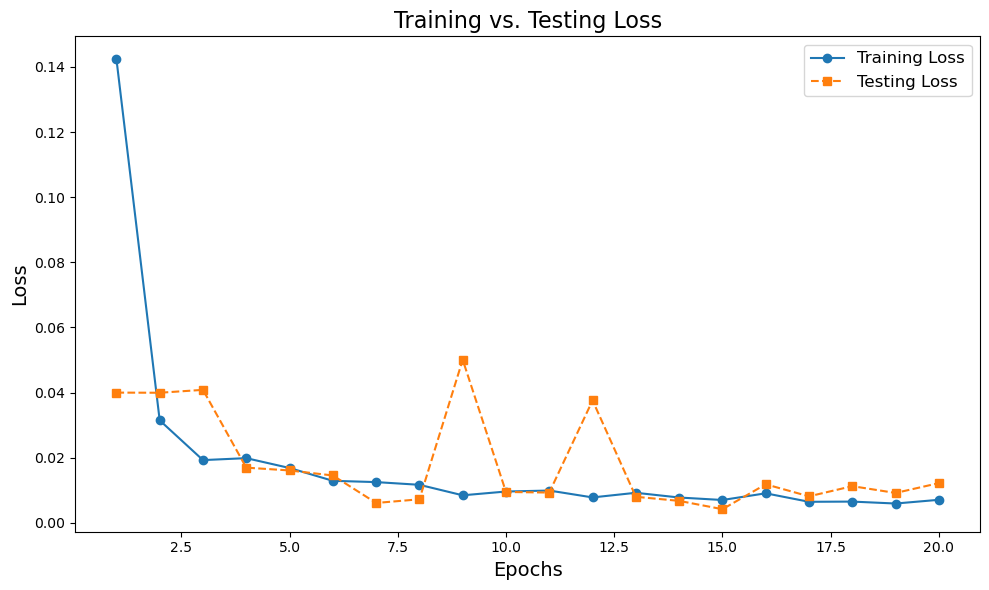

In [31]:
plot_results(results)

### 6. Save and Load Model

In [32]:
def save_model(model, filepath):
    """
    Save the PyTorch model to the specified file path.

    Args:
    - model (torch.nn.Module): The model to save.
    - filepath (str): The file path where the model will be saved.
    """
    # Save the model's state dictionary (weights)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [33]:
def load_model(model_class, model_args, path, device):
    """
    Loads the model's state_dict from a specified path into an instance of the model class.

    Args:
        model_class: The class of the model (must be initialized before loading state_dict).
        model_args: A dictionary containing arguments required to initialize the model class.
        path: The file path where the model is saved (e.g., "model.pth").
        device: The device where the model should be loaded (e.g., "cpu" or "cuda").
    
    Returns:
        model: The model with loaded weights.
    """
    try:
        # Initialize the model with the provided arguments
        model = model_class(**model_args)
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        print(f"Model loaded successfully from {path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [34]:
save_model(model, "./model/deep_wide_recommendation_model.pth")

Model saved to ./model/deep_wide_recommendation_model.pth


In [37]:
model_args = {
    'num_customers': num_customers,          # Total number of customers
    'num_products': num_products,           # Total number of products
    'num_categories': num_categories,       # Total number of categories
    'embedding_dim': embedding_dim,         # Embedding size
    'num_numerical_features': num_numerical_features             # Number of numerical features
}

loaded_model = load_model(DeepWideRecommendationModel, model_args, "./model/deep_wide_recommendation_model.pth", device = device)

Model loaded successfully from ./model/deep_wide_recommendation_model.pth
